# Import

In [15]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import glob, os
from glob import glob
import matplotlib.pyplot as plt
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)
import random
import cv2

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from torchsummary import summary

# Check localization of data

In [16]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [17]:
data_dir = ''

In [18]:
# Verification of the number of Images 

# load filenames for human and dog images
size = 0
size = np.array(glob(data_dir+"images/*"))

# Check one image
#Image.open(open("/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg", 'rb'))

# print number of images in each dataset
print('There are %d total images.' % len(size))

sample_csv = pd.read_csv(data_dir + 'sample_submission.csv')
test_csv = pd.read_csv(data_dir + 'test.csv')
train_csv = pd.read_csv(data_dir + 'train.csv')

train_csv

There are 3642 total images.


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


# Creation of custom datasheet

In [23]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for 
        # image collection via CV2
    
        image_cv2 = cv2.imread(os.path.join(self.root, img_name), cv2.IMREAD_COLOR)
        
        image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
        
        
        if self.transform is not None:
            transformed = self.transform(image=image_cv2)
            image_cv2 = transformed['image']
            
        # define the label based on the idx
        if self.transform == train_transforms or self.transform == valid_transforms:
            label_target = self.data.iloc[idx, 1:5].values.astype('int64')
            label_target = np.argwhere(label_target ==1)
            label_target = label_target.item(0)
            label_target = torch.tensor(label_target)
            #print(label_target)
        else:
            label_target = torch.tensor(0)
        
        # Label of the data
        if self.transform == train_transforms or self.transform == valid_transforms:
            label = self.data.loc[idx, self.id]
            label = int(label[6:])
            label = torch.tensor(label)
        else:
            label = self.data.loc[idx, self.id]
            #print(label)
            label = int(label[5:])
            label = torch.tensor(label)
        
        return image_cv2, label_target, label
'''    
train_transforms = transforms.Compose([
        transforms.RandomRotation(45),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ToTensor()  
])

train_transforms = A.Compose([
    A.RandomResizedCrop(height=400, width=400, p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),
    A.OneOf([
        A.IAAEmboss(p=1.0),
        A.IAASharpen(p=1.0),
        A.Blur(p=1.0),
    ], p=0.5),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)
])

'''
Size = 244

train_transforms = A.Compose([
    A.Resize(height=Size, width=Size, p=1.0),
    RandomRotate90(p=0.5),
    Flip(p=0.5),
    Transpose(p=0.5),
    #OneOf([
    #    IAAAdditiveGaussianNoise(),
    #    GaussNoise(),
    #], p=0.2),
    #OneOf([
    #    MotionBlur(p=0.1),
    #    MedianBlur(blur_limit=3, p=0.1),
    #    Blur(blur_limit=3, p=0.1),
    #], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    #OneOf([
    #    OpticalDistortion(p=0.3),
    #    GridDistortion(p=0.1),
    #    IAAPiecewiseAffine(p=0.3),
    #], p=0.2),
    #OneOf([
    #    CLAHE(clip_limit=2),
    #    IAASharpen(p=1.0),
    #    IAAEmboss(),
    #    RandomBrightnessContrast(1.0),
    #], p=1.0),
    IAASharpen(p=1.0),
    #CLAHE(clip_limit=2),
    IAAAdditiveGaussianNoise(),
    HueSaturationValue(p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
    #A.Normalize(mean=(0.406, 0.456, 0.485), std=(0.225, 0.224, 0.229), p=1.0),
    #A.Normalize(),
    ToTensorV2(p=1.0),
])
 
valid_transforms = A.Compose([
    A.Resize(height=Size, width=Size, p=1.0), 
    A.Normalize(p=1.0), 
    ToTensorV2(p=1.0)
])
    
test_transforms = A.Compose([
    A.Resize(height=Size, width=Size, p=1.0), 
    A.Normalize(p=1.0), 
    ToTensorV2(p=1.0)
])


params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
}

In [24]:
image_dataset = {x: CustomDataset(csv_file=data_dir+'train.csv', 
                                   root_dir=data_dir+'images', 
                                   **params,
                                   transform=train_transforms if x == 'train' 
                                            else valid_transforms if x == 'valid' 
                                            else test_transforms) 
                 for x in ['train', 'valid', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size = 4,  shuffle=True) 
               for x in ['train', 'valid', 'test']}

print('TRAINING')
img, lab_target, lab = image_dataset['train'].__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image size at the first row: {}'.format(img.shape))
print('\nTarget at the first row: ', lab_target)
print('Target format at the first row: {}'.format(lab_target))
print('Target format at the first row: {}'.format(lab_target.shape))
print('\nLab at the first row: ', lab)
print('lab format at the first row: {}'.format(lab))
print('lab format at the first row: {}'.format(lab.shape))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

images, labels_target, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('Type of tensor for the image from the batchsize = {}'.format(images.float().type()))
print('images shape on batch size = ', images.shape)
print('\nTaregt type on batch size = {}'.format(labels_target))
print('Target type on batch size = {}'.format(type(labels_target)))
print('Target shape on batch size = ', labels_target.shape)
print('\nlabels type on batch size = {}'.format(labels))
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = ', labels.shape)



TRAINING
DATASET
image at the first row:  torch.Size([3, 244, 244])
image size at the first row: torch.Size([3, 244, 244])

Target at the first row:  tensor(3)
Target format at the first row: 3
Target format at the first row: torch.Size([])

Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
Type of tensor for the image from the batchsize = torch.FloatTensor
images shape on batch size =  torch.Size([4, 3, 244, 244])

Taregt type on batch size = tensor([2, 3, 3, 3])
Target type on batch size = <class 'torch.Tensor'>
Target shape on batch size =  torch.Size([4])

labels type on batch size = tensor([1805,  200, 1353, 1473])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size =  torch.Size([4])


## Dataset Visualization

# tranform impact on image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1. the image 395 target is multiple_diseases
2. the image 103 target is healthy
3. the image 1666 target is healthy
4. the image 151 target is healthy


<Figure size 432x288 with 0 Axes>

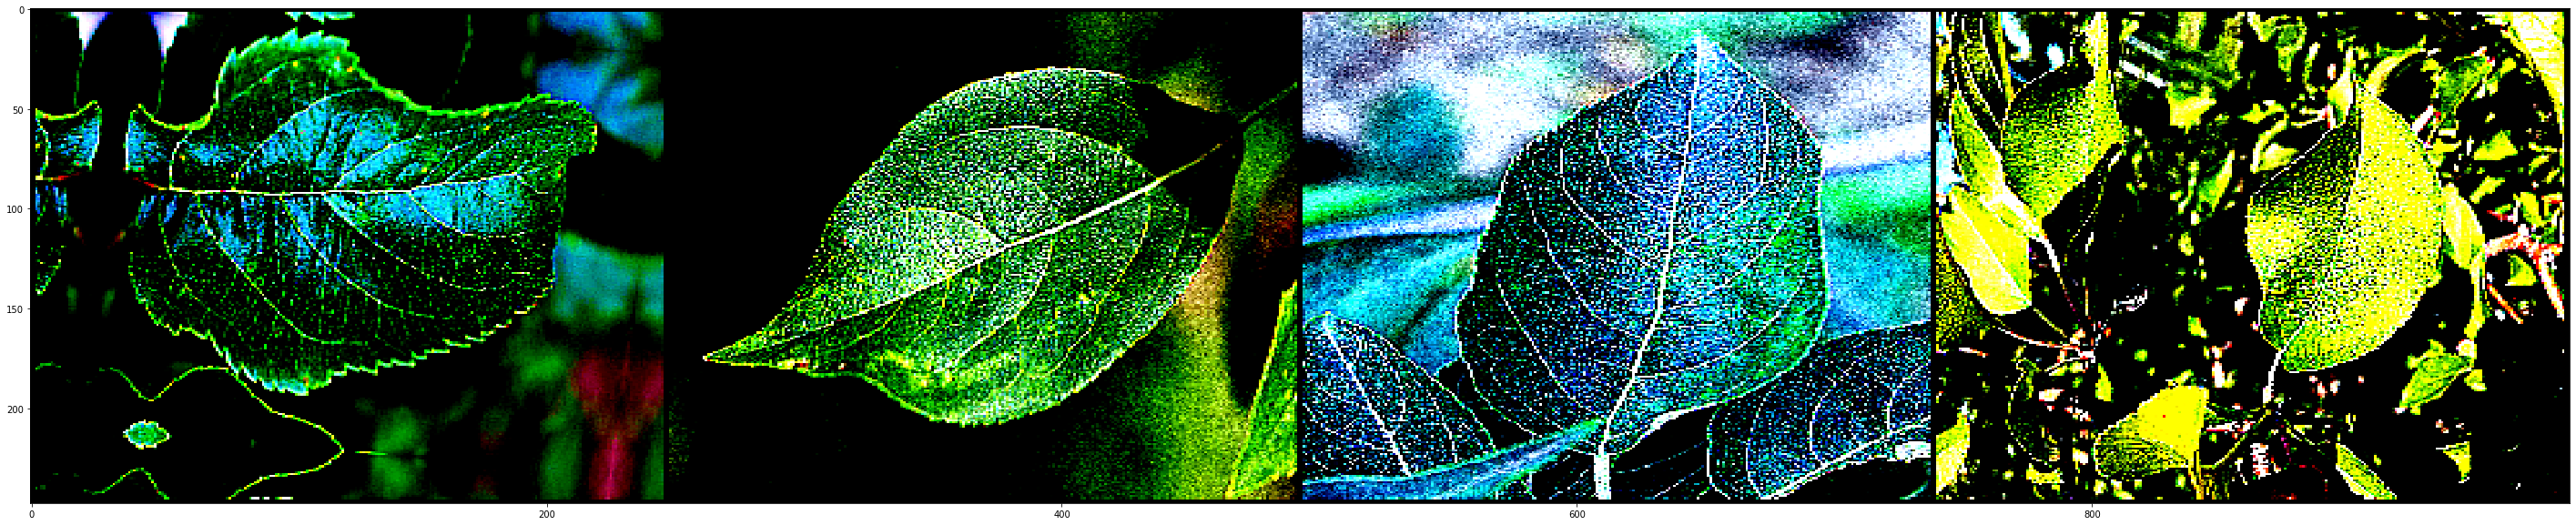

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

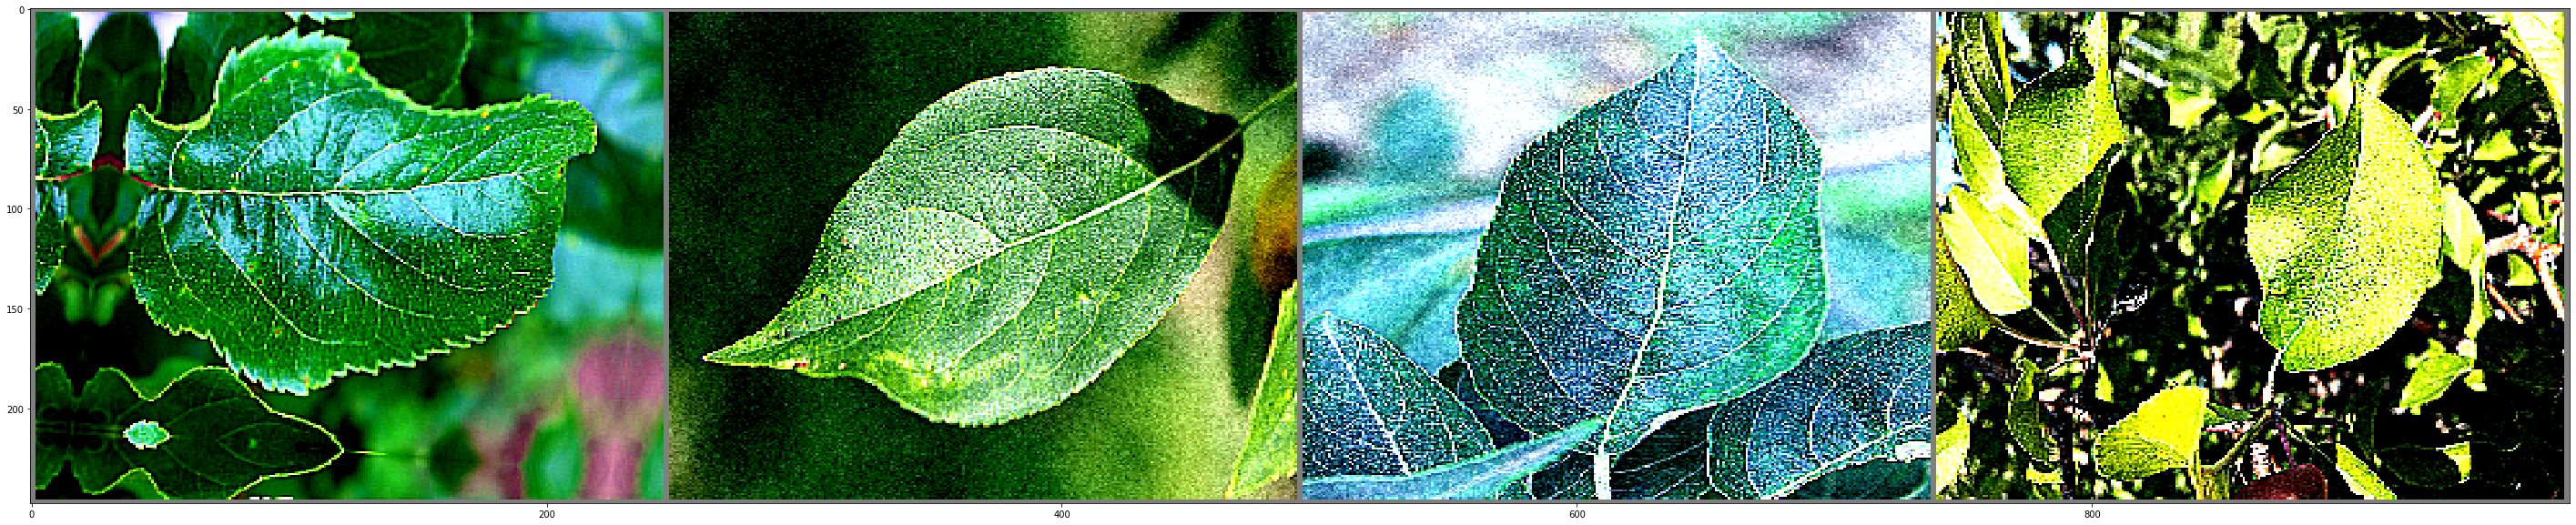

In [25]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(data_loader['train'])
#print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
#print('image test data',images_test_data)
images_target_label = images_test[1]
#print(len(images_target_label))
images_label = images_test[2]
#print(len(images_label))

for i in range(len(images_target_label)):
    print('{}. the image {} target is {}'.format(i+1,images_label[i].numpy(), classes[images_target_label[i].numpy()]))

def imshow(img):
    # image from transform
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()
    
    # image unormalize
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))

# Model

In [26]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # CNN1
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv11= nn.Conv2d(8, 8, 2, padding=0)
        self.conv111= nn.Conv2d(8, 8, 2, padding=0)
        
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv22 = nn.Conv2d(16, 16, 2, padding=0)
        self.conv222 = nn.Conv2d(16, 16, 2, padding=0)
        
        # CNN2
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv33 = nn.Conv2d(32, 32, 2, padding=0)
        self.conv333 = nn.Conv2d(32, 32, 2, padding=0)
        
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv44 = nn.Conv2d(64, 64, 2, padding=0)
        self.conv444 = nn.Conv2d(64, 64, 2, padding=0)
        
        #CNN3
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv55 = nn.Conv2d(128, 128, 2, padding=0)
        self.conv555 = nn.Conv2d(128, 128, 2, padding=0)
        
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv66 = nn.Conv2d(256, 256, 2, padding=0)
        self.conv666 = nn.Conv2d(256, 256, 2, padding=0)
        
        #CNN4
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv77 = nn.Conv2d(512, 512, 2, padding=0)
        self.conv777 = nn.Conv2d(512, 512, 2, padding=0)
        
        self.conv8 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv88 = nn.Conv2d(1024, 1024, 2, padding=0)
        self.conv888 = nn.Conv2d(1024, 1024, 2, padding=0)
        
        '''
        # CL sees 56 x 56 x 32
        #self.conv4 = nn.Conv2d(512, 512, 2, padding=0)
        self.conv4 = nn.Conv2d(512, 1024, 2, padding=0)
        self.batchnorm1014 = nn.BatchNorm2d(1024)
        
        #CL 
        self.conv5 = nn.Conv2d(1024, 2048, 2, padding=0)
        self.batchnorm2048 = nn.BatchNorm2d(2048)
        '''
        #batchNorm
        self.batchnorm8 = nn.BatchNorm2d(8)
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)
        #self.batchnorm2048 = nn.BatchNorm2d(2048)
        
        # Activation function
        #self.activate = F.leaky_relu()
        
        # Max pooling layer
        self.MAXpool = nn.MaxPool2d(3, 3)
        self.AVGpool = nn.AvgPool2d(3, 3)
        
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(1024 * 1 * 1, 500)
        
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        
        # linear layer (250 -> 125)
        self.fc3 = nn.Linear(250, 125)
        
        # linear layer (250 -> 4)
        self.fc4 = nn.Linear(125, 4)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout2d(0.3)
        
        # LogSoftmax
        self.LogSM = nn.LogSoftmax()
    
    def forward(self, x):
        ## Define forward behavior
        # 1st CNN
        # 3 => 8
        x = self.conv1(x)
        x = self.conv11(x)
        x = self.conv111(x)
        
        x = F.leaky_relu(x)
        x = self.batchnorm8(x)
        
        # 16 => 32
        x = self.conv2(x)
        x = self.conv22(x)
        x = self.conv222(x)
        
        x = F.leaky_relu(x)
        x = self.batchnorm16(x)
        
        # AVGpool and Dropout
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 2nd Cnn
        # 16 => 32
        x = self.conv3(x)
        x = self.conv33(x)
        x = self.conv333(x)
        
        x = F.leaky_relu(x)
        x = self.batchnorm32(x)
        
        # 32 => 64
        x = self.conv4(x)
        x = self.conv44(x)
        x = self.conv444(x)
        
        x = F.leaky_relu(x)
        x = self.batchnorm64(x)
        
        # AVGpool and Dropout
        x = self.MAXpool(x)
        x = self.dropout(x)
        
        # 3rd CNN
        # 64 => 128
        x = self.conv5(x)
        x = self.conv55(x)
        x = self.conv555(x)
        
        x = F.leaky_relu(x)
        x = self.batchnorm128(x)
        
        # 128 => 256
        x = self.conv6(x)
        x = self.conv66(x)
        x = self.conv666(x)
        
        x = F.leaky_relu(x)
        x = self.batchnorm256(x)
        
        # AVGpool and Dropout
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 4th CNN
        # 256 => 512
        x = self.conv7(x)
        x = self.conv77(x)
        x = self.conv777(x)
        
        x = self.batchnorm512(x)
        
        # 512 => 1024
        x = self.conv8(x)
        x = self.conv88(x)
        x = self.conv888(x)
        
        x = self.batchnorm1024(x)

        # AVGpool and Dropout
        x = self.MAXpool(x)
        x = self.dropout(x)
       
        # flatten image input
        #print(x.shape)
        x = x.view(-1, 1024 * 1 * 1)
        #x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        #h3
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        #h4
        x = self.fc4(x)
        x = self.LogSM(x)

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_patho = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_patho.cuda()


In [27]:
summary(Net(),input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 244, 244]             224
            Conv2d-2          [-1, 8, 243, 243]             264
            Conv2d-3          [-1, 8, 242, 242]             264
       BatchNorm2d-4          [-1, 8, 242, 242]              16
            Conv2d-5         [-1, 16, 242, 242]           1,168
            Conv2d-6         [-1, 16, 241, 241]           1,040
            Conv2d-7         [-1, 16, 240, 240]           1,040
       BatchNorm2d-8         [-1, 16, 240, 240]              32
         AvgPool2d-9           [-1, 16, 80, 80]               0
        Dropout2d-10           [-1, 16, 80, 80]               0
           Conv2d-11           [-1, 32, 80, 80]           4,640
           Conv2d-12           [-1, 32, 79, 79]           4,128
           Conv2d-13           [-1, 32, 78, 78]           4,128
      BatchNorm2d-14           [-1, 32,

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:195: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Result

Res: 0.986

input: 244 x 244

Normalization: Yes

In [28]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_patho.parameters(), lr=0.001, momentum = 0.9)

In [29]:
LR_START = 0.0001
LR_MAX = 0.00005 # * num_replicas_in_sync
LR_MIN = 0.001
LR_RAMPUP_EPOCHS = 6
LR_SUSTAIN_EPOCHS = 10
LR_EXP_DECAY = 0.8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr



In [30]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        LR = lrfn(epoch)
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target,_) in enumerate(loaders['train']):

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            #optimizer.zero_grad()
            optim.SGD(model.parameters(), lr=LR, momentum=0.9).zero_grad()
            # add data.float() as the data is in ByteTensor format, which doesn't work the model data type
            output = model(data)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            #optimizer.step()
            optim.SGD(model.parameters(), lr=LR, momentum=0.9).step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        model.eval()
        for idx, (data, target, _) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            LR
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), 'model_patho_12052020.pt'))
                 )
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [31]:
# model_res = train(10, data_loader, model_patho, optimizer, criterion)



In [38]:
model_res = Net()

# load the model that got the best validation accuracy
# model_res.load_state_dict(torch.load('model_patho_11052020_2.pt'))

model_res = torch.load(''+'model_patho_11052020_2.pt', map_location=torch.device('cpu'))

model_res

OrderedDict([('conv1.weight',
              tensor([[[[ 8.8069e-02, -1.9914e-01, -5.1292e-02],
                        [-5.4966e-02,  6.9401e-02, -4.8183e-02],
                        [ 1.9590e-01, -7.0247e-02, -2.6960e-01]],
              
                       [[-1.0183e-01, -1.0802e-01, -1.8400e-01],
                        [ 7.8281e-02,  1.4224e-01,  1.2830e-01],
                        [-8.4510e-02,  2.0390e-01,  2.5274e-01]],
              
                       [[-1.0710e-01,  1.2852e-01,  2.2504e-01],
                        [ 1.0868e-01,  3.1741e-02, -1.0133e-01],
                        [-2.2436e-01, -2.6065e-02, -1.1365e-01]]],
              
              
                      [[[-2.7213e-02,  5.9747e-03, -2.4635e-01],
                        [ 1.5509e-02, -8.1504e-02, -2.2981e-01],
                        [ 5.2842e-02,  2.2756e-01,  1.0821e-01]],
              
                       [[-4.5401e-03, -2.4815e-02,  8.7573e-02],
                        [ 1.8862e-01, -6.7782

# TEST

In [39]:
image_dataset = {x: CustomDataset(csv_file=data_dir+'test.csv', 
                                   root_dir=data_dir+'images', 
                                   **params,
                                   transform=train_transforms if x == 'train' 
                                            else valid_transforms if x == 'valid' 
                                            else test_transforms) 
                 for x in ['train', 'valid', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size = 4,  shuffle=True) 
               for x in ['train', 'valid', 'test']}

print('TRAINING')
img_test, lab_target_test, lab_test = image_dataset['test'].__getitem__(0)

print('DATASET TEST')
print('image at the first row: {}', img_test.shape)
print('image size at the first row: {}'.format(img_test.size()))
print('\nTarget at the first row: ', lab_target_test)
print('Target format at the first row: {}'.format(lab_target_test))
print('Target shape at the first row: {}'.format(lab_target_test.shape))
print('\nLab at the first row: ', lab_test)
print('lab format at the first row: {}'.format(lab_test))
print('lab format at the first row: {}'.format(lab_test.shape))

print()
print('Train Loader type')
test_iter = iter(data_loader['test'])
print(type(test_iter))


images_test, _, labels_test = test_iter.next()
print()
print('DATALOADER TEST')
print('images test',images_test[0][0][0][0])
print('images type on batch size = {}'.format(type(images_test)))
print('images shape on batch size = {}', images_test.shape)
print('\nlabels type on batch size = {}'.format(type(labels_test)))
print('labels shape on batch size = {}', labels_test)

TRAINING
DATASET TEST
image at the first row: {} torch.Size([3, 244, 244])
image size at the first row: torch.Size([3, 244, 244])

Target at the first row:  tensor(0)
Target format at the first row: 0
Target shape at the first row: torch.Size([])

Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER TEST
images test tensor(-0.6794)
images type on batch size = <class 'torch.Tensor'>
images shape on batch size = {} torch.Size([4, 3, 244, 244])

labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size = {} tensor([ 235,  277,  705, 1706])


data_iter


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image test data tensor([[[[-1.5528, -1.5528, -1.5528,  ..., -0.5253, -0.5767, -0.7308],
          [-1.5185, -1.5014, -1.5185,  ..., -0.5424, -0.5253, -0.5767],
          [-1.4843, -1.4672, -1.4500,  ..., -0.4911, -0.4739, -0.5082],
          ...,
          [-1.5357, -1.4843, -1.4843,  ...,  0.1083,  0.3481,  0.8961],
          [-1.5357, -1.5014, -1.5185,  ...,  0.0056,  0.0227,  0.5193],
          [-1.5185, -1.5528, -1.4843,  ..., -0.0116, -0.2513,  0.2111]],

         [[-1.3880, -1.3880, -1.3354,  ..., -0.2675, -0.3375, -0.4951],
          [-1.3529, -1.3354, -1.3004,  ..., -0.1975, -0.2850, -0.3375],
          [-1.3004, -1.2829, -1.2129,  ..., -0.1275, -0.2150, -0.2675],
          ...,
          [-1.2829, -1.2304, -1.1779,  ...,  0.5203,  0.7129,  1.0280],
          [-1.2829, -1.2479, -1.2129,  ...,  0.5028,  0.5203,  1.0980],
          [-1.3179, -1.2304, -1.2479,  ...,  0.4853,  0.3452,  0.7129]],

         [[-1.4210, -1.4210, -1.3861,  ..., -0.9330, -1.0027, -1.1596],
          [-1.

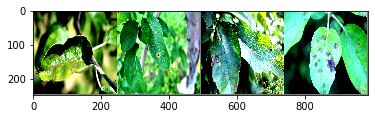

In [40]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(data_loader['test'])
print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
print('image test data',images_test_data)
images_test_label = images_test[1]
print(images_test_label)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [44]:
model_test = Net()
model_test.load_state_dict(torch.load(''+'model_patho_11052020_2.pt', map_location=torch.device('cpu')))
model_test = model_test.eval()

out_fwd = model_test.forward(images_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
top_probs, top_labs = probs.topk(4)
print('top_probs:\n {} \n top_labs:\n {}'.format(top_probs, top_labs))
print(classes[top_labs[0][0].detach().numpy()])
print(classes[top_labs[1][0].detach().numpy()])
print(classes[top_labs[2][0].detach().numpy()])
print(classes[top_labs[3][0].detach().numpy()])


Result preditcion model on dataset:
 tensor([[-0.8937, -3.0094, -3.8609, -0.6530],
        [-8.0177, -3.0802, -0.0478, -7.7244],
        [-3.0243, -1.7724, -0.3297, -2.7751],
        [-2.5794, -3.4600, -5.9567, -0.1164]], grad_fn=<LogSoftmaxBackward>)

probs
 tensor([[4.0915e-01, 4.9323e-02, 2.1049e-02, 5.2047e-01],
        [3.2957e-04, 4.5949e-02, 9.5328e-01, 4.4191e-04],
        [4.8590e-02, 1.6993e-01, 7.1914e-01, 6.2340e-02],
        [7.5821e-02, 3.1429e-02, 2.5883e-03, 8.9016e-01]],
       grad_fn=<ExpBackward>)
top_probs:
 tensor([[5.2047e-01, 4.0915e-01, 4.9323e-02, 2.1049e-02],
        [9.5328e-01, 4.5949e-02, 4.4191e-04, 3.2957e-04],
        [7.1914e-01, 1.6993e-01, 6.2340e-02, 4.8590e-02],
        [8.9016e-01, 7.5821e-02, 3.1429e-02, 2.5883e-03]],
       grad_fn=<TopkBackward>) 
 top_labs:
 tensor([[3, 0, 1, 2],
        [2, 1, 3, 0],
        [2, 1, 3, 0],
        [3, 0, 1, 2]])
scab
rust
rust
scab


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:195: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Submission

In [45]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')

submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,0,0
1,Test_1,0,0,0,0
2,Test_2,0,0,0,0
3,Test_3,0,0,0,0
4,Test_4,0,0,0,0


In [46]:
submission_df_test = pd.read_csv(data_dir + 'sample_submission.csv')

model_test = Net()
model_test.load_state_dict(torch.load(''+'model_patho_11052020_2.pt', map_location=torch.device('cpu')))
model_test = model_test.eval()

for idx, (data, _, label) in enumerate(data_loader['test']):
    images_data = data
    #print(images_data)
    label_data = label
    #print(label_data)   
    probs = torch.exp(model_test(images_data))
    #print(probs)
    label_data = label_data.numpy()
    #print(label_data)
    probs = probs.detach().numpy()
    #print(probs)
    for i in range(len(label_data)):
        #print(i)
        ind = label_data[i]
        #print(ind)
        res_probs = probs[i]
        #print(res_probs)
        res_add = ['Test_'+str(ind), res_probs[0], res_probs[1],res_probs[2],res_probs[3]]
        submission_df_test.loc[ind] = res_add         
        
pd.set_option("display.max_rows", 10, "display.max_columns", None)
print(submission_df_test)
submission_df_test.to_csv(path_or_buf='sample_submission_11052020_2_jpt.csv', index=False)


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:195: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


       image_id   healthy  multiple_diseases      rust      scab
0        Test_0  0.000543           0.050610  0.948321  0.000526
1        Test_1  0.006221           0.100057  0.886431  0.007291
2        Test_2  0.022814           0.010332  0.000156  0.966697
3        Test_3  0.878467           0.008106  0.004058  0.109369
4        Test_4  0.000021           0.018824  0.981140  0.000015
...         ...       ...                ...       ...       ...
1816  Test_1816  0.000081           0.025871  0.973977  0.000072
1817  Test_1817  0.163275           0.102462  0.052789  0.681474
1818  Test_1818  0.007773           0.103057  0.880861  0.008309
1819  Test_1819  0.951193           0.002364  0.000976  0.045467
1820  Test_1820  0.254604           0.110499  0.114762  0.520135

[1821 rows x 5 columns]
